In [25]:
#reference - https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing

In [26]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [27]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [28]:
# Goal - node classification
# Input - a subset of nodes with ground truth labels
# Output - predict the labels of remaining nodes (transductive learning)
# Dataset - Cora - a citation network where nodes represent documents. 
#           Each node is described by a 1433-dimensional bag-of-words feature vector. 
#           Two documents are connected if there exists a citation link between them. 
#           The task is to infer the category of each document (7 in total)

In [29]:
# Cora dataset is made available as part of PyG under the Planetoid name
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# Data exploration
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Graph statistics - total nodes = 2708, total edges = 10556
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [30]:
# Train a multi layer perceptron, as just by checking the content of a document (bag-of-words feature representation), 
# it should be possible to categorize it 

In [31]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

# model architecture
# layer 1 : reduce the 1433-dimensional feature vector to a low-dimensional embedding (hidden_channels=16), 
# layer 2 : Classifier that should map each resultant low-dimensional node embedding to one of the 7 classes.

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [32]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [33]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


In [34]:
# Accuracy is pretty low :
# possible causes - (i) small labeled data leading to overfitting 
#                   (ii) Cited papers are very likely related to the category of a document - edge information

In [35]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # below we convert to GNN by replacing Linear with GCNConv
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


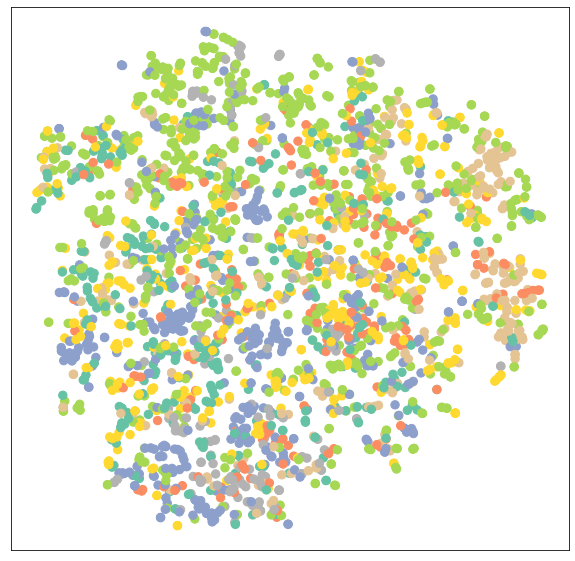

In [36]:
# visualize the node embeddings of untrained GCN network - poor quality clustering
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [37]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # optimizer
criterion = torch.nn.CrossEntropyLoss() # loss criterion

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9451
Epoch: 002, Loss: 1.9384
Epoch: 003, Loss: 1.9307
Epoch: 004, Loss: 1.9227
Epoch: 005, Loss: 1.9126
Epoch: 006, Loss: 1.9076
Epoch: 007, Loss: 1.8917
Epoch: 008, Loss: 1.8809
Epoch: 009, Loss: 1.8728
Epoch: 010, Loss: 1.8616
Epoch: 011, Loss: 1.8453
Epoch: 012, Loss: 1.8397
Epoch: 013, Loss: 1.8237
Epoch: 014, Loss: 1.8057
Epoch: 015, Loss: 1.7979
Epoch: 016, Loss: 1.7808
Epoch: 017, Loss: 1.7667
Epoch: 018, Loss: 1.7555
Epoch: 019, Loss: 1.7436
Epoch: 020, Loss: 1.7184
Epoch: 021, Loss: 1.7126
Epoch: 022, Loss: 1.6845
Epoch: 023, Loss: 1.6717
Epoch: 024, Loss: 1.6673
Epoch: 025, Loss: 1.6353
Epoch: 026, Loss: 1.6181
Epoch: 027, Loss: 1.5962
Epoch: 028, Loss: 1.5723
Epoch: 029, Loss: 1.5708
Epoch: 030, Loss: 1.5370
Epoch: 031, Loss: 1.5162
Epoch: 032, Loss: 1.4948
Epoch: 033, Loss: 1.4713
Epoch: 034, Loss: 1.4589
Epoch: 035, Loss: 1.4479
Epoch: 036, Loss: 1.4377
Epoch: 037, Loss: 1.4271
Epoch: 038, Loss: 1.3644
Epoch: 039, Loss: 1.3658
Epoch: 040, Loss: 1.3363


In [38]:
# much better accuracy
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


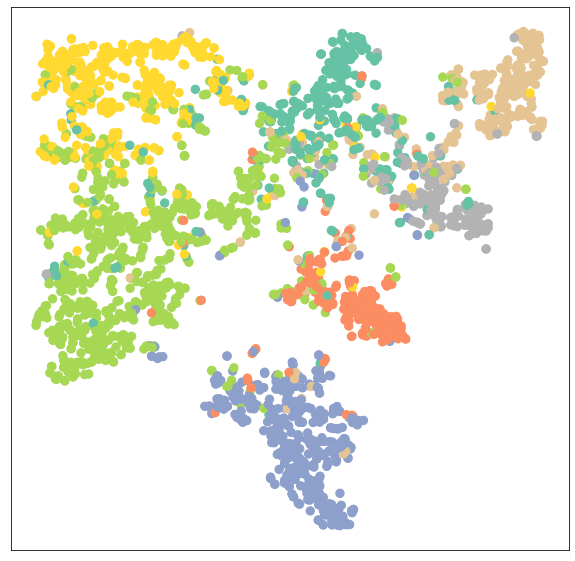

In [39]:
# visualize the node embeddings of trained GCN network - improved quality clustering
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)